In [1]:
from __future__ import absolute_import, division, print_function

import os
#import urllib, cStringIO

import pymongo as pm

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/home/megsano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

### load dataframe

In [13]:
D = pd.read_csv(os.path.join(results_dir,'graphical_conventions.csv'))

In [15]:
### add session ids for recog experiment (delete later)

In [48]:
# create tuple for each gameID, target pair 
D_repeated = D[D['condition'] == 'repeated']
repeated_tuple_list = []
for g in D_repeated['gameID'].unique():
    target_list = D_repeated[D_repeated['gameID'] == g]['target'].unique()
    for t in target_list:
        repeated_tuple_list.append((g, t))
repeated = np.array(repeated_tuple_list)
assert len(repeated) == 268 
        
# create tuple for each gameID, target pair 
D_control = D[D['condition'] == 'control']
control_tuple_list = []
for g in D_control['gameID'].unique():
    target_list = D_control[D_control['gameID'] == g]['target'].unique()
    for t in target_list:
        control_tuple_list.append((g, t))
control = np.array(control_tuple_list)
assert len(control) == 268 

# create new dataframe with gameID, tuple pairs 
new_d = pd.DataFrame()
for rep in range(8):
    new_d['repeated_rep_{}'.format(rep)] = list(np.roll(repeated, rep * 4, axis=0))
for rep in [0,7]:
    new_d['control_rep_{}'.format(rep)] = list(np.roll(control, (rep+8) * 4, axis=0))
    
# add recog sesion ids to main dataframe 
D['recog_id'] = [0] * len(D)
for i,d in new_d.iterrows():
    for j, pair in enumerate(list(d)):
        if j == 8 or j == 9:
            condition = 'control' 
            rep_num = 0 if j == 8 else 1
        else:
            condition = 'repeated'
            rep_num = j
        row_index = list(D.index[(D['gameID'] == pair[0]) & (D['target'] == pair[1]) & (D['repetition'] == rep_num) & (D['condition'] == condition)])[0]
        D.loc[row_index, 'recog_id'] = i

In [130]:
## to do 
# add target shapenet ids 
target_shapenets = [0] * len(D)
D['target_shapenet'] = target_shapenets
for i,d in D.iterrows():
    target = d['target']
    shapenet_id = h.object_to_shapenet[target]
    D.loc[i, 'target_shapenet'] = shapenet_id

['waiting_07' 'waiting_04' 'waiting_00' 'waiting_01']


In [147]:
# add distractor 
# add shapenet ids for distractors
distractors = [[0]] * len(D)
distractors_shapenets = [[0]] * len(D)
D['distractors'] = distractors 
D['distractors_shapenet'] = distractors_shapenets
for i,d in D.iterrows():
    gameID = d['gameID']
    condition = d['condition']
    target_list = D[(D['gameID'] == gameID) & (D['condition'] == condition)]['target'].unique()
    distractors_list = [target for target in target_list if target !=  d['target']]
    distractors_dict = {'distractor1':distractors_list[0],'distractor2':distractors_list[1],'distractor3':distractors_list[2]}
    D.at[i, 'distractors'] = distractors_dict
    shapenets_list = [h.object_to_shapenet[dist] for dist in distractors_list]
    shapenets_dict = {'distractor1':shapenets_list[0],'distractor2':shapenets_list[1],'distractor3':shapenets_list[2]}
    D.at[i, 'distractors_shapenet'] = shapenets_dict

In [146]:
D

,row_index,gameID,trialNum,condition,target,category,repetition,phase,Generalization,drawDuration,...,numCurvesPerSketch,numCurvesPerStroke,timedOut,png,svgString,crazy,recog_id,target_shapenet,distractors,distractors_shapenet
0,0,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,1,repeated,waiting_07,waiting,0,pre,within,5.415,...,7,2.333333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,105c0,-10.99517 24.80021,-15 32,-15c18....",False,0,309674bdec2d24d7597976c675750537,"{u'distractors1': u'waiting_04', u'distractors...",{u'distractors1': u'2b5953c986dd08f2f91663a74c...
1,1,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,2,control,waiting_02,waiting,0,pre,within,12.327,...,14,2.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M76,71c11.17833,22.35667 13,51.12344 13,76'...",False,32,2448d9aeda5bb9b0f4b6538438a0b930,"{u'distractors1': u'waiting_06', u'distractors...",{u'distractors1': u'2eaab78d6e4c4f2d7b0c85d2ef...
2,2,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,3,control,waiting_06,waiting,0,pre,within,9.014,...,10,2.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M99,73c9.76816,0 21.5598,-9.5672 31,-13c12....",False,33,2eaab78d6e4c4f2d7b0c85d2effc7e09,"{u'distractors1': u'waiting_02', u'distractors...",{u'distractors1': u'2448d9aeda5bb9b0f4b6538438...
3,3,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,4,repeated,waiting_04,waiting,0,pre,within,9.451,...,17,4.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M93,78c9.09243,9.09243 54.37526,-8.31237 67...",False,1,2b5953c986dd08f2f91663a74ccd2338,"{u'distractors1': u'waiting_07', u'distractors...",{u'distractors1': u'309674bdec2d24d7597976c675...
4,4,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,5,repeated,waiting_00,waiting,0,pre,within,8.538,...,11,3.666667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M100,201c1.11783,1.11783 2,-29.63433 2,-36c...",False,2,1d1641362ad5a34ac3bd24f986301745,"{u'distractors1': u'waiting_07', u'distractors...",{u'distractors1': u'309674bdec2d24d7597976c675...
5,5,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,6,repeated,waiting_01,waiting,0,pre,within,8.660,...,13,3.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,122c27.20942,0 54.44369,-3 81,-3', u'M8...",False,3,1da9942b2ab7082b2ba1fdc12ecb5c9e,"{u'distractors1': u'waiting_07', u'distractors...",{u'distractors1': u'309674bdec2d24d7597976c675...
6,6,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,7,control,waiting_03,waiting,0,pre,within,3.443,...,5,5.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M89,153c0,-29.24917 -0.39833,-63.92033 35,-...",False,34,23b0da45f23e5fb4f4b6538438a0b930,"{u'distractors1': u'waiting_02', u'distractors...",{u'distractors1': u'2448d9aeda5bb9b0f4b6538438...
7,7,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,8,control,waiting_05,waiting,0,pre,within,9.140,...,13,6.500000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M112,174c0,2.78464 -2.4007,79.4007 -4,81c-1...",False,35,2e291f35746e94fa62762c7262e78952,"{u'distractors1': u'waiting_02', u'distractors...",{u'distractors1': u'2448d9aeda5bb9b0f4b6538438...
8,8,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,9,repeated,waiting_00,waiting,1,repeated,within,8.248,...,12,6.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M93,205c6.54424,0 2.21105,-20.08284 3,-26c4...",False,6,1d1641362ad5a34ac3bd24f986301745,"{u'distractors1': u'waiting_07', u'distractors...",{u'distractors1': u'309674bdec2d24d7597976c675...
9,9,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,10,repeated,waiting_07,waiting,1,repeated,within,3.628,...,7,3.500000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M180,140c-13.06007,0 -68.96917,5.06166 -56,...",False,4,309674bdec2d24d7597976c675750537,"{u'distractors1': u'waiting_04', u'distractors...",{u'distractors1': u'2b5953c986dd08f2f91663a74c...


In [142]:
D.to_csv(os.path.join(results_dir, 'graphical_conventions.csv'))
check = pd.read_csv(os.path.join(results_dir, 'graphical_conventions.csv'))
check

,Unnamed: 0,row_index,gameID,trialNum,condition,target,category,repetition,phase,Generalization,...,numCurvesPerSketch,numCurvesPerStroke,timedOut,png,svgString,crazy,recog_id,target_shapenet,distractors,distractors_shapenet
0,0,0,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,1,repeated,waiting_07,waiting,0,pre,within,...,7,2.333333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,105c0,-10.99517 24.80021,-15 32,-15c18....",False,0,309674bdec2d24d7597976c675750537,"['waiting_04', 'waiting_00', 'waiting_01']","['2b5953c986dd08f2f91663a74ccd2338', '1d164136..."
1,1,1,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,2,control,waiting_02,waiting,0,pre,within,...,14,2.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M76,71c11.17833,22.35667 13,51.12344 13,76'...",False,32,2448d9aeda5bb9b0f4b6538438a0b930,"['waiting_06', 'waiting_03', 'waiting_05']","['2eaab78d6e4c4f2d7b0c85d2effc7e09', '23b0da45..."
2,2,2,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,3,control,waiting_06,waiting,0,pre,within,...,10,2.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M99,73c9.76816,0 21.5598,-9.5672 31,-13c12....",False,33,2eaab78d6e4c4f2d7b0c85d2effc7e09,"['waiting_02', 'waiting_03', 'waiting_05']","['2448d9aeda5bb9b0f4b6538438a0b930', '23b0da45..."
3,3,3,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,4,repeated,waiting_04,waiting,0,pre,within,...,17,4.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M93,78c9.09243,9.09243 54.37526,-8.31237 67...",False,1,2b5953c986dd08f2f91663a74ccd2338,"['waiting_07', 'waiting_00', 'waiting_01']","['309674bdec2d24d7597976c675750537', '1d164136..."
4,4,4,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,5,repeated,waiting_00,waiting,0,pre,within,...,11,3.666667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M100,201c1.11783,1.11783 2,-29.63433 2,-36c...",False,2,1d1641362ad5a34ac3bd24f986301745,"['waiting_07', 'waiting_04', 'waiting_01']","['309674bdec2d24d7597976c675750537', '2b5953c9..."
5,5,5,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,6,repeated,waiting_01,waiting,0,pre,within,...,13,3.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,122c27.20942,0 54.44369,-3 81,-3', u'M8...",False,3,1da9942b2ab7082b2ba1fdc12ecb5c9e,"['waiting_07', 'waiting_04', 'waiting_00']","['309674bdec2d24d7597976c675750537', '2b5953c9..."
6,6,6,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,7,control,waiting_03,waiting,0,pre,within,...,5,5.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M89,153c0,-29.24917 -0.39833,-63.92033 35,-...",False,34,23b0da45f23e5fb4f4b6538438a0b930,"['waiting_02', 'waiting_06', 'waiting_05']","['2448d9aeda5bb9b0f4b6538438a0b930', '2eaab78d..."
7,7,7,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,8,control,waiting_05,waiting,0,pre,within,...,13,6.500000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M112,174c0,2.78464 -2.4007,79.4007 -4,81c-1...",False,35,2e291f35746e94fa62762c7262e78952,"['waiting_02', 'waiting_06', 'waiting_03']","['2448d9aeda5bb9b0f4b6538438a0b930', '2eaab78d..."
8,8,8,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,9,repeated,waiting_00,waiting,1,repeated,within,...,12,6.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M93,205c6.54424,0 2.21105,-20.08284 3,-26c4...",False,6,1d1641362ad5a34ac3bd24f986301745,"['waiting_07', 'waiting_04', 'waiting_01']","['309674bdec2d24d7597976c675750537', '2b5953c9..."
9,9,9,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,10,repeated,waiting_07,waiting,1,repeated,within,...,7,3.500000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M180,140c-13.06007,0 -68.96917,5.06166 -56,...",False,4,309674bdec2d24d7597976c675750537,"['waiting_04', 'waiting_00', 'waiting_01']","['2b5953c986dd08f2f91663a74ccd2338', '1d164136..."


### load sketch features + metadata

In [6]:
reload(h)
cropping = 'no_crop'
base_path = '../../../data/features/'
path_to_feats = base_path + '{}/FEATURES_FC6_sketch.npy'.format(cropping)
path_to_meta = base_path + '{}/METADATA_sketch.csv'.format(cropping)

F = np.load(path_to_feats)
cors = np.corrcoef(F)
triu_inds = np.triu_indices(cors.shape[0], k = 1)
assert np.round(np.mean(cors[triu_inds]),2) != 1, 'F has redundant rows'

M = h.clean_up_metadata(pd.read_csv(path_to_meta))
assert F.shape[0]==M.shape[0], 'F and M are different sizes'

## core analyses

### 1. within-interaction

##### accuracy

In [9]:
# what's the mean accuracy?
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
print ("accuracy: {}".format(meanAccuracy))

accuracy: 0.858582089552


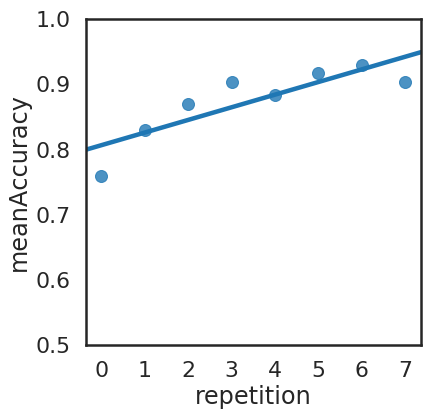

In [10]:
# plot mean accuracy across repetitions 
reload(h)
h.plot_accuracy_reps(D)

##### efficiency (based on cost and accuracy)

In [4]:
reload(h) ## write out bis dataframe 
drawDuration_accuracy_bis, numStrokes_accuracy_bis = h.save_bis_scores(D)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


##### sketch similarity convergence 

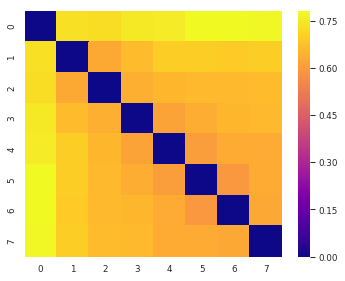

In [42]:
# ### create matrix for similarity between adjacent repetitions averaged within target and within game
reload(h)
arr_of_cormats = h.make_adjacency_matrix(M, F, 'gameID')

In [35]:
check = D[(D['category'] == 'waiting') & (D['condition'] == 'repeated') & (D['repetition'] == 0)]
check.head(1500)

,Unnamed: 0,gameID,trialNum,condition,target,category,repetition,phase,Generalization,drawDuration,outcome,response,numStrokes,meanPixelIntensity,numCurvesPerSketch,numCurvesPerStroke,timedOut,png,svgString,crazy
0,0,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,1,repeated,waiting_07,waiting,0,pre,within,5.415,True,waiting_07,3.0,0.0068,7,2.333333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,105c0,-10.99517 24.80021,-15 32,-15c18....",False
3,3,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,4,repeated,waiting_04,waiting,0,pre,within,9.451,False,waiting_00,4.0,0.0203,17,4.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M93,78c9.09243,9.09243 54.37526,-8.31237 67...",False
4,4,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,5,repeated,waiting_00,waiting,0,pre,within,8.538,True,waiting_00,3.0,0.0202,11,3.666667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M100,201c1.11783,1.11783 2,-29.63433 2,-36c...",False
5,5,7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb,6,repeated,waiting_01,waiting,0,pre,within,8.660,True,waiting_01,4.0,0.0165,13,3.250000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M87,122c27.20942,0 54.44369,-3 81,-3', u'M8...",False
40,40,3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25,1,repeated,waiting_07,waiting,0,pre,within,9.105,True,waiting_07,6.0,0.0203,14,2.333333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M175,123c-14.62345,0 -55,-7.33126 -55,14c0,...",False
41,41,3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25,2,repeated,waiting_03,waiting,0,pre,within,6.296,False,waiting_07,5.0,0.0155,8,1.600000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M96,157c8.00646,16.01292 58.27188,22.15208 ...",False
42,42,3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25,3,repeated,waiting_00,waiting,0,pre,within,6.504,True,waiting_00,2.0,0.0205,14,7.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M64,45c0,5.86324 -3.84213,33.15787 0,37c0.7...",False
44,44,3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25,5,repeated,waiting_05,waiting,0,pre,within,15.434,True,waiting_05,6.0,0.0276,36,6.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M108,79c-3.32727,3.32727 -3.46774,55.53226 ...",False
81,81,6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8,2,repeated,waiting_06,waiting,0,pre,within,11.921,True,waiting_06,6.0,0.0374,15,2.500000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M55,66c11.7897,9.43176 28.96637,12.62124 42...",False
83,83,6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8,4,repeated,waiting_07,waiting,0,pre,within,9.728,True,waiting_07,6.0,0.0362,18,3.000000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...,"[u'M65,65c11.87307,0 27.5062,10.06939 41,11c31...",False


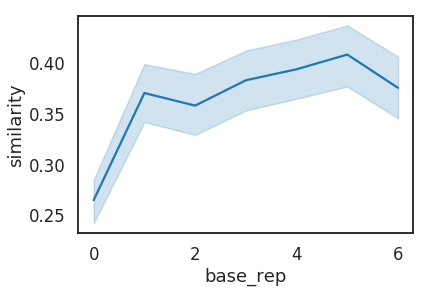

In [39]:
h.plot_within_interaction_similarity(arr_of_corrmats)

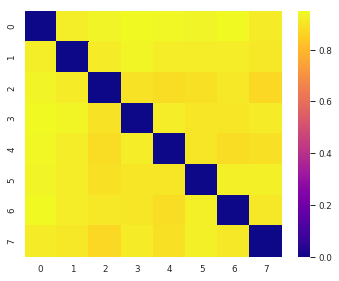

In [41]:
### permute across repetitions and create matrix for similarity between adjacent repetitions averaged within target and within game
M_pseudo = h.scramble_df_within_target_rep(M)
arr_of_corrmats_permuted = h.make_adjacency_matrix(M_pseudo, F, 'pseudo_gameID')

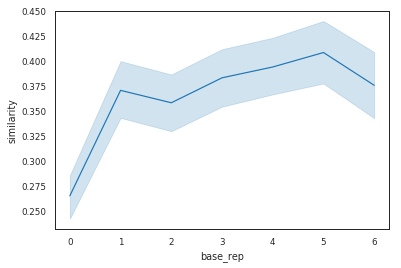

In [44]:
### just plotting one back similarities 
h.plot_within_interaction_similarity(arr_of_corrmats)

### 2. between-interaction

##### sketch similarity divergence 

In [45]:
### calculates similarity of sketches between interactions within a repetition 
h.plot_between_interaction_similarity(M)

/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:816: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

## supplementary analyses

In [68]:
# plotting 8 RDMs, one for each repetition 
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(40,20))
for rep in range(8): 
    x_ind = rep % 4
    y_ind = 0 if rep < 4 else 1 
    M_rep = M[M['repetition'] == str(int(rep))]
    M_rep_sorted = M_rep.sort_values(by=['target'])
    sorted_feature_ind = list(M_rep_sorted['feature_ind'])
    get_and_plot_RDM(M_rep, F, sorted_feature_ind, axs, x_ind, y_ind, rep)

saving sketches from game: 7053-d1f771d6-a55b-4681-961f-5a9ebb43cbdb
saving sketches from game: 3558-8fa206a2-9b8c-4d67-a4ab-0832dc0d0f25
saving sketches from game: 6964-d6de9966-f3dd-45df-8d24-d5bfd5d46eb8
saving sketches from game: 4853-a05bfdd7-095c-4b93-bdde-2b99fd29c7a2
saving sketches from game: 5616-7114c020-0e81-482c-952b-b26fc66076a0
saving sketches from game: 9817-6f2a66db-fc24-482d-aa20-1980ad6f524e
saving sketches from game: 7527-5ab8c64c-3f95-4864-bb6a-f9cad4b0d34e
saving sketches from game: 1820-86afdf51-4b4c-43a9-a9e1-e6e20618de1b
saving sketches from game: 7438-c77fa69e-d41c-41a4-b530-fc2809c07323
saving sketches from game: 9075-d6c9b0a6-bfb2-4148-ae19-d0da518aef97
saving sketches from game: 7637-26870e81-faae-4521-a2e9-10424526a22c
saving sketches from game: 4395-6cdb78e3-0c3f-4526-9670-8e4c1dcbc542
saving sketches from game: 3480-03933bf3-5e7e-4ecd-b151-7ae57e6ae826
saving sketches from game: 7360-1ccf92da-d46d-4315-8c81-6620388ee62f
saving sketches from game: 8103-96

##### path-dependence

In [ ]:
def get_corr_coefs(M,F):
    auto_corr_df = pd.DataFrame()
    for g in list(M['gameID'].unique()):
        for t in list(M[M['gameID'] == g]['target'].unique()):
            mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
            #mini_df = M[(M['gameID'] == '0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82') & (M['target'] == 'dining_05')] 
            for base_rep in mini_df['repetition'].unique():
                base_ind = list(mini_df[mini_df['repetition'] == base_rep]['feature_ind'])[0]
                for other_rep in mini_df['repetition'].unique():
                    if base_rep < other_rep:# check if other_rep is bigger - only compare forward 
                        rep_dist = other_rep - base_rep
                        other_ind = list(mini_df[mini_df['repetition'] == other_rep]['feature_ind'])[0]
                        features_to_compare = F[[base_ind, other_ind], :]
                        corr_coef = np.corrcoef(features_to_compare)[1][0]
                        df_to_add = pd.DataFrame([[g, t, base_rep,  rep_dist, corr_coef]], columns=['gameID', 'target', 'base_rep', 'rep_dist', 'corr_coef'])
                        auto_corr_df = auto_corr_df.append(df_to_add)
    return auto_corr_df

auto_corr_df = get_corr_coefs(M, F)

In [ ]:
# how does the similarity between sketches of adjacent repetitions change with increasing base repetition number? 
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='base_rep',
    y='corr_coef',
    logx=True)

In [ ]:
# how does the similarity between sketches of adjacent repetitions change with increasing repetition distance? 
sns.regplot(
    data=auto_corr_df,
    x_estimator=np.mean,
    x='rep_dist',
    y='corr_coef')

In [ ]:
new_df_ = pd.DataFrame()
for rep in auto_corr_df['base_rep'].unique():
    df_ = auto_corr_df[auto_corr_df['base_rep'] == rep]
    for dist in df_['rep_dist'].unique():
        _df = df_[df_['rep_dist'] == dist]
        mean = np.mean(np.array(_df['corr_coef']))
        df_to_add = pd.DataFrame([[rep, dist, mean]], columns=['base_rep', 'rep_dist', 'mean_corr_coef'])
        new_df_ = new_df_.append(df_to_add)

In [ ]:
g = sns.FacetGrid(data=new_df_, col="rep_dist", height=3, aspect=1, col_wrap=4, margin_titles=True)
g = g.map(plt.scatter, "base_rep", "mean_corr_coef")
# g = sns.catplot(x="base_rep", y="mean_corr_coef",
#                 col="rep_dist", data=new_df_,col_wrap=2)

##### classifier approach

In [ ]:
#sklearn
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
# make dataframe with just the first repetition 
M_0 = M[M['repetition'] == 0]
y = list(M_0['target'])
feature_inds = list(M_0['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(x, y, test_size = 0.2)

# make dataframe with just the last repetition 
M_7 = M[M['repetition'] == 7]
y = list(M_7['target'])
feature_inds = list(M_7['feature_ind'])
features = F[feature_inds, :]
x = pd.DataFrame(features)

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(x, y, test_size = 0.2)

In [ ]:
# makes training and testing sets for sketches from specific repetition 
def make_sets(M, rep):
    # make dataframe with just the last repetition 
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return train_test_split(x, y, test_size = 0.2)

In [ ]:
# make either training set or testing set (all sketches used for either one of them)
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [ ]:
def classify_sketches(train_rep, test_rep):
    summary_df = pd.DataFrame()
    for i in range(1):
    
        # first train on the train_rep sketches
        X_train_, y_train_= get_x_and_y(M, train_rep)
        logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
        #clf = CalibratedClassifierCV(log) 
        logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

        # for each repetition, predict from features, record accuracy and class probability    
        for rep in test_rep:
            X_test, y_test = get_x_and_y(M, rep)
            y_pred = logreg.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            prob = logreg.predict_proba(X_test)
            prob_df_svc = pd.DataFrame(prob)
            prob_df_svc.columns=list(logreg.classes_)
            prob_df_svc['target'] = y_test
            prob_list = []
            prob_df_svc = prob_df_svc.reset_index(drop=True)
            for j, d in prob_df_svc.iterrows():
                target = d['target']
                class_prob = d[target]
                prob_list.append(class_prob)
            mean_prob = np.mean(prob_list)

            df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
            summary_df = summary_df.append(df_to_add)

    return summary_df

In [ ]:
summary_df0 = classify_sketches(0, [1,7])
summary_df7 = classify_sketches(7, [6,0])
summary_df0['train_rep'] = [0] * summary_df0.shape[0]
summary_df7['train_rep'] = [7] * summary_df7.shape[0]
summary_df_list = [summary_df0, summary_df7]
combined_df = pd.concat(summary_df_list, axis=0)
combined_df = combined_df.reset_index(drop=True)
distance_list = []
for i,d in combined_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
combined_df['distance'] = distance_list
combined_df = combined_df.reset_index(drop=True)

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=combined_df,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

In [ ]:
def get_x_and_y_permute(M, rep):
    M_= M[M['pseudo_repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

In [ ]:
def classify_sketches_permute(train_rep, test_rep):
    summary_df = pd.DataFrame()
    
    # first train on the train_rep sketches
    X_train_, y_train_= get_x_and_y_permute(M, train_rep)
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    #clf = CalibratedClassifierCV(log) 
    logreg.fit(X_train_, y_train_)
#         svc = LinearSVC(random_state=0)
#         clf = CalibratedClassifierCV(svc) 
#         clf.fit(X_train_, y_train_)

    # for each repetition, predict from features, record accuracy and class probability    
    for rep in test_rep:
        X_test, y_test = get_x_and_y_permute(M, rep)
        y_pred = logreg.predict(X_test)
        acc = accuracy_score(y_test, y_pred) # temporarily just do accuracy 
#         prob = logreg.predict_proba(X_test)
#         prob_df_svc = pd.DataFrame(prob)
#         prob_df_svc.columns=list(logreg.classes_)
#         prob_df_svc['target'] = y_test
#         prob_list = []
#         prob_df_svc = prob_df_svc.reset_index(drop=True)
#         for j, d in prob_df_svc.iterrows():
#             target = d['target']
#             class_prob = d[target]
#             prob_list.append(class_prob)
        mean_prob = 1#np.mean(prob_list)

        df_to_add = pd.DataFrame([[i, rep, acc, mean_prob]], columns=['iteration','test_rep', 'accuracy', 'class_prob'])
        summary_df = summary_df.append(df_to_add)

    return summary_df

In [ ]:
final_combined_df_permute = pd.DataFrame()
random_seed = 4000000000
for i in range(1000):
    if i % 100 == 0:
        print (str(i) + "th iteration")
    pseudo_rep_list = []
    for g in list(M['gameID'].unique()):
        for t in list(M[M['gameID'] == g]['target'].unique()):
            mini_df = M[(M['gameID'] == g) & (M['target'] == t)] 
            rep_list = np.array(mini_df['repetition'])
            # pass in different random seed for each one 
            np.random.seed(random_seed)
            shuffled_rep_list = np.random.permutation(rep_list)
            pseudo_rep_list = pseudo_rep_list + list(shuffled_rep_list)
            random_seed = random_seed - 1
    M['pseudo_repetition'] = pseudo_rep_list
    summary_df0 = classify_sketches_permute(0, [1,7])
    summary_df7 = classify_sketches_permute(7, [6,0])
    summary_df0['train_rep'] = [0] * summary_df0.shape[0]
    summary_df7['train_rep'] = [7] * summary_df7.shape[0]
    summary_df_list = [summary_df0, summary_df7]
    combined_df_permute = pd.concat(summary_df_list, axis=0)
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    distance_list = []
    for j,d in combined_df_permute.iterrows():
        distance_list.append(abs(d['test_rep']-d['train_rep']))
    combined_df_permute['distance'] = distance_list
    combined_df_permute = combined_df_permute.reset_index(drop=True)
    final_combined_df_permute = final_combined_df_permute.append(combined_df_permute)#add(combined_df_permute, fill_value=0)
result = final_combined_df_permute / 1000

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
g = sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")
g.set(ylim=(0.5, 0.6))

In [ ]:
sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=final_combined_df_permute,
    x='distance',
    y='accuracy',
    hue='train_rep',
    palette="Set1")

##### bootstrap

In [ ]:
# make either training set or testing set (all sketches used for either one of them)
from sklearn.metrics import log_loss
def get_x_and_y(M, rep):
    M_= M[M['repetition'] == rep]
    y = list(M_['target'])
    feature_inds = list(M_['feature_ind'])
    features = F[feature_inds, :]
    x = pd.DataFrame(features)
    return x, y

def get_training_set_error(train_rep):
    X_train, y_train = get_x_and_y(M, train_rep)
    targets = pd.Series(y_train).unique()
    logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    logreg.fit(X_train, y_train)
    #y_pred = logreg.predict(X_test)
    y_pred = logreg.predict_proba(X_train)
    # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
    classification_loss = log_loss(y_train, y_pred, labels=targets)
    return classification_loss

In [ ]:
games = list(M['gameID'].unique())
#targets = list(M['target'].unique())
number_of_games = len(games)

bootstrap_samples = []
for i in range(1000):
    sample = np.random.choice(number_of_games, number_of_games)
    bootstrap_samples.append(sample)
    
def get_error(train_rep, test_rep):
    
    #grand_total_classification_loss = 0
    err_df = pd.DataFrame()
    for g in games:
        print("computing average classification loss for game " + g + " with train rep: " + str(train_rep) + " and test rep: " + str(test_rep))

        samples_without_g = [sample for sample in bootstrap_samples if games.index(g) not in sample] 
        total_classification_loss = 0
        training_set_error = get_training_set_error(train_rep)
        sample_index=0
        for sample in samples_without_g:
            games_ = pd.Series(games)
            sample_games = games_[sample] # sample is just a list of indices, so get actual games 
            sample_games = list(sample_games)
            M_train = M[M['gameID'].isin(sample_games)]
            X_train, y_train = get_x_and_y(M_train, train_rep)
            targets = pd.Series(y_train).unique()
            M_test = M[M['gameID'] == g]
            X_test, y_test = get_x_and_y(M_test, test_rep)
            logreg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
            logreg.fit(X_train, y_train)
            #y_pred = logreg.predict(X_test)
            y_pred = logreg.predict_proba(X_test)
            # train classifier on these sample sketches from repetition (train) and test on sketches from game g repetition (test)
            classification_loss = log_loss(y_test, y_pred, labels=targets)
            total_classification_loss = total_classification_loss + classification_loss
            sample_index=sample_index+1
        average_classification_loss = total_classification_loss / len(samples_without_g)
        error = 0.632 * average_classification_loss + 0.368 * training_set_error
        df_to_add = pd.DataFrame([[error, g, sample_index, train_rep, test_rep]], columns=['error', 'gameID', 'sample_index', 'train_rep', 'test_rep'])
        err_df = err_df.append(df_to_add)
        #grand_total_classification_loss = grand_total_classification_loss + average_classification_loss
    #grand_average_classification_loss = grand_total_classification_loss / len(games)

    #error_632 = 0.632 * grand_average_classification_loss + 0.368 * training_set_error 
    return err_df

# df_0_1 = get_error(0,1)
# df_0_1.to_csv("df_0_1.csv")
df_0_7 = get_error(0,7)
df_0_7.to_csv("df_0_7.csv")
df_7_6 = get_error(7,6)
df_7_6.to_csv("df_7_6.csv")
df_7_0 = get_error(7,0)
df_7_0.to_csv("df_7_0.csv")

In [ ]:
df_0_1 = pd.read_csv("df_0_1.csv")
all_err_df = pd.concat([df_0_1, df_0_7, df_7_6, df_7_0])
all_err_df.to_csv("all_err_df.csv")

In [ ]:
# convert to and add distance 
all_err_df = pd.read_csv("all_err_df.csv")
distance_list = []
for j,d in all_err_df.iterrows():
    distance_list.append(abs(d['test_rep']-d['train_rep']))
all_err_df['distance'] = distance_list

sns.set_context("paper")
plt.figure(figsize=(5,5))
sns.pointplot(
    data=all_err_df,
    x='distance',
    y='error',
    hue='train_rep',
    palette="Set1")